In [1]:

import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F

from torch import optim
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
import pandas as pd

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


### Data Class

In [2]:
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float64))
        self.y = torch.from_numpy(y.astype(np.float64)).type(torch.LongTensor)
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], np.array(self.y[index])
   
    def __len__(self):
        return self.len


### Loading Data

In [3]:
batch_size = 10

train_data = torch.load("train")
test_data = torch.load("test")

train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

#for batch, (X, y) in enumerate(train_dataloader):
    #print(f"Batch: {batch+1}")
    #print(f"X shape: {X.shape}")
    #print(f"y shape: {y.shape}")
   

In [4]:
print(test_data.X.shape)

torch.Size([42071, 300])


## Visualizing Data

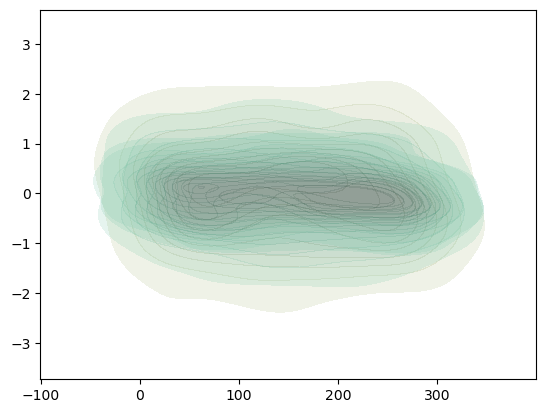

In [5]:
import random
colors = []
import pandas as pd
import matplotlib.pyplot as plt 
palette = sns.color_palette("Spectral", n_colors=70)

counter = 0
df = pd.DataFrame(columns = ['category', 'vector', 'color'])


for X, Y in test_dataloader:

    random_ind = [random.randint(0,len(test_dataloader)) for i in range(0,5)]
    
    for y in Y:
        if(counter in random_ind):
            sns.kdeplot(x=[i for i in range(0,300)],y=X[0], color=palette[y],common_norm=False, fill=True,alpha=.2)
        counter+=1

plt.show()

    

In [16]:
import umap.umap_ as umap

umap_embedding = umap.UMAP(n_neighbors = 100).fit_transform(test_data.X)
fig, ax = plt.subplots()
labels_num = np.array([test_data.y[name] for name in test_data.y])
scatter = ax.scatter(umap_embedding.T[0], umap_embedding.T[1], s=0.03, c=labels_num, cmap='Spectral')
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
#plt.rcParams['figure.figsize'] = [10, 10]

plt.title("Doc2Vec Embedding Space & Umap")
fig.savefig('temp.png', dpi=fig.dpi, bbox_inches='tight', pad_inches=0.5)
plt.show()

### Experimenting with Transformations

In [7]:
print(test_data.X.shape)


torch.Size([42071, 300])


In [8]:
print(len(np.unique(test_data.y)))
print(len(np.unique(train_data.y)))

31
32


In [10]:
from sklearn.decomposition import PCA
ncomp_pca = 35
pca_70 = PCA(n_components = ncomp_pca, random_state=2000,svd_solver = 'full')

pca_70.fit(np.vstack((test_data.X, train_data.X)))
test_data.X = torch.from_numpy(pca_70.transform(test_data.X).astype(np.float64))
train_data.X = torch.from_numpy(pca_70.transform(train_data.X).astype(np.float64))

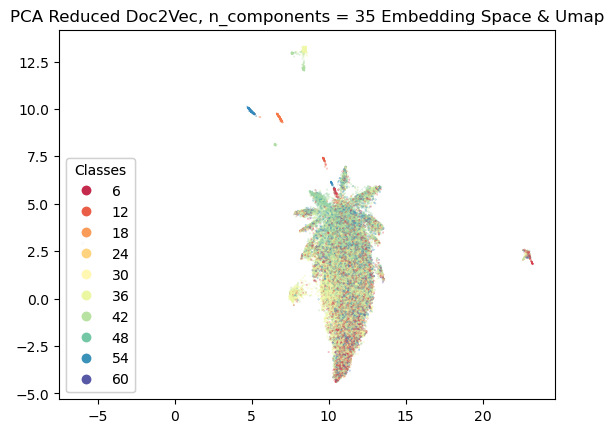

In [10]:
umap_embedding = umap.UMAP(n_neighbors = 100).fit_transform(test_data.X)
fig, ax = plt.subplots()
labels_num = np.array([test_data.y[name] for name in test_data.y])
scatter = ax.scatter(umap_embedding.T[0], umap_embedding.T[1], s=0.03, c=labels_num, cmap='Spectral')
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
#plt.rcParams['figure.figsize'] = [10, 10]

plt.title("PCA Reduced Doc2Vec, n_components = " + str(ncomp_pca) +  " Embedding Space & Umap")
fig.savefig('temp2.png', dpi=fig.dpi, bbox_inches='tight', pad_inches=0.5)
plt.show()
#test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)
#train_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

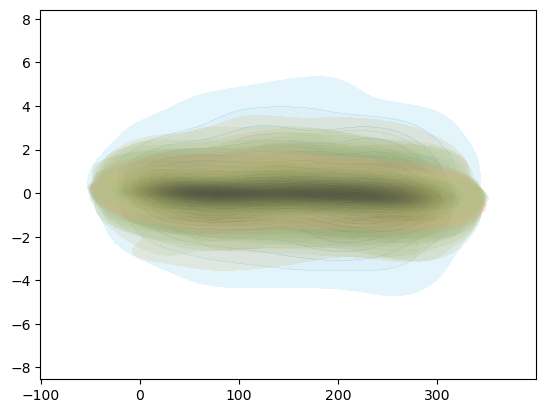

In [6]:
counter=0
for X, Y in test_dataloader:
    random_ind = [random.randint(0,len(test_dataloader)) for i in range(0,100)]
    
    for y in Y:
        #print(len(Y))
        if(counter in random_ind):
            #print('plotting')
            sns.kdeplot(x=[i for i in range(0,test_data.X.shape[1])],y=X[0], color=palette[y],common_norm=False, fill=True,alpha=.2)
        counter+=1

plt.show()

### Network Class

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        
        #conv1d: 1d channels, out channels, kernel size, stride, padding
        self.conv1 = nn.Conv1d(300, 300, kernel_size=7, padding="same")
        self.linear_middle = nn.Linear(300, 300)
        self.conv2 = nn.Conv1d(300, 300, kernel_size=7, padding="same")
        self.linear_final = nn.Linear(300, 70)
        self.pooling = nn.MaxPool1d(2)
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.linear_aux = nn.Linear(70,70)



    def forward(self, x):
        x = x.to(torch.float32)
        #x = x.reshape(len(x),150,150)
        x = x.reshape(len(x), 300, 1) ## Embedding Length needs to be treated as channel dimension
        x = F.relu(self.conv1(x))
        #x = self.pooling(x)
        x = self.leakyrelu(self.conv2(x))
        #x = self.leakyrelu(self.conv2(x))
        #x = self.leakyrelu(self.conv2(x))
        #x = self.leakyrelu(self.conv2(x))
        #x = self.leakyrelu(self.conv2(x))
        #x = self.leakyrelu(self.conv2(x))
        x = self.leakyrelu(self.conv2(x))
        x, _ = x.max(dim=-1)
        x = F.relu(self.linear_final(x))
        x = self.linear_aux(x)
        return x

### Initializing Network

In [8]:
input_dim = 150
hidden_dim = 150
output_dim = 70



model = NeuralNetwork(input_dim, hidden_dim, output_dim)


criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #e-1
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 100
loss_values = []

### Training Network

In [9]:

from tqdm import tqdm

large_losses = []
for epoch in range(num_epochs):
    losses = []
    for X, Y in tqdm(train_dataloader):
        #print(X.shape)
        Y_preds = model(X)
        # zero the parameter gradients

        loss = criterion(Y_preds, Y)
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    large_losses.append(sum(losses)/len(losses))
    print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        # forward + backward + optimize

        




100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:07<00:00, 250.28it/s]


Train Loss : 2.170


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:05<00:00, 255.79it/s]


Train Loss : 1.761


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:03<00:00, 263.29it/s]


Train Loss : 1.579


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:04<00:00, 261.88it/s]


Train Loss : 1.442


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:02<00:00, 270.56it/s]


Train Loss : 1.336


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:05<00:00, 256.99it/s]


Train Loss : 1.259


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:00<00:00, 277.98it/s]


Train Loss : 1.197


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:05<00:00, 255.01it/s]


Train Loss : 1.141


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:00<00:00, 276.22it/s]


Train Loss : 1.089


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:02<00:00, 270.88it/s]


Train Loss : 1.044


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:00<00:00, 280.02it/s]


Train Loss : 0.999


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:00<00:00, 277.67it/s]


Train Loss : 0.958


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:02<00:00, 270.36it/s]


Train Loss : 0.921


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:01<00:00, 273.82it/s]


Train Loss : 0.887


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:01<00:00, 273.60it/s]


Train Loss : 0.853


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:01<00:00, 272.30it/s]


Train Loss : 0.821


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:02<00:00, 270.73it/s]


Train Loss : 0.793


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:04<00:00, 262.13it/s]


Train Loss : 0.765


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:03<00:00, 264.43it/s]


Train Loss : 0.738


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:02<00:00, 270.56it/s]


Train Loss : 0.713


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:02<00:00, 269.43it/s]


Train Loss : 0.688


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:04<00:00, 260.04it/s]


Train Loss : 0.665


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:04<00:00, 260.02it/s]


Train Loss : 0.643


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:03<00:00, 266.58it/s]


Train Loss : 0.623


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:01<00:00, 273.16it/s]


Train Loss : 0.606


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:03<00:00, 265.46it/s]


Train Loss : 0.588


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:02<00:00, 267.81it/s]


Train Loss : 0.567


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:01<00:00, 271.68it/s]


Train Loss : 0.556


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:03<00:00, 264.44it/s]


Train Loss : 0.538


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:03<00:00, 263.27it/s]


Train Loss : 0.523


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:02<00:00, 271.13it/s]


Train Loss : 0.509


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:03<00:00, 263.07it/s]


Train Loss : 0.498


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:03<00:00, 262.97it/s]


Train Loss : 0.485


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:06<00:00, 253.86it/s]


Train Loss : 0.471


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:04<00:00, 261.53it/s]


Train Loss : 0.463


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:02<00:00, 270.15it/s]


Train Loss : 0.459


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:01<00:00, 273.58it/s]


Train Loss : 0.442


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:03<00:00, 266.90it/s]


Train Loss : 0.434


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:02<00:00, 267.82it/s]


Train Loss : 0.424


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:05<00:00, 258.63it/s]


Train Loss : 0.414


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:02<00:00, 267.86it/s]


Train Loss : 0.407


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:01<00:00, 274.73it/s]


Train Loss : 0.399


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:01<00:00, 271.84it/s]


Train Loss : 0.387


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:01<00:00, 271.60it/s]


Train Loss : 0.383


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:16<00:00, 218.90it/s]


Train Loss : 0.382


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:55<00:00, 145.31it/s]


Train Loss : 0.372


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [02:03<00:00, 136.51it/s]


Train Loss : 0.367


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:01<00:00, 273.60it/s]


Train Loss : 0.357


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [00:59<00:00, 283.46it/s]


Train Loss : 0.344


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [00:59<00:00, 284.71it/s]


Train Loss : 0.344


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:04<00:00, 261.18it/s]


Train Loss : 0.338


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:05<00:00, 256.75it/s]


Train Loss : 0.337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:02<00:00, 270.10it/s]


Train Loss : 0.331


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:01<00:00, 274.20it/s]


Train Loss : 0.341


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:00<00:00, 277.76it/s]


Train Loss : 0.321


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:05<00:00, 255.01it/s]


Train Loss : 0.316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:00<00:00, 276.15it/s]


Train Loss : 0.313


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:01<00:00, 274.17it/s]


Train Loss : 0.303


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:00<00:00, 276.68it/s]


Train Loss : 0.293


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:04<00:00, 262.92it/s]


Train Loss : 0.303


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:05<00:00, 257.99it/s]


Train Loss : 0.284


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:00<00:00, 277.35it/s]


Train Loss : 0.286


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:06<00:00, 252.14it/s]


Train Loss : 0.297


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:09<00:00, 242.90it/s]


Train Loss : 0.297


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:05<00:00, 256.85it/s]


Train Loss : 0.287


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:06<00:00, 253.78it/s]


Train Loss : 0.270


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:03<00:00, 263.72it/s]


Train Loss : 0.268


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:01<00:00, 274.95it/s]


Train Loss : 0.269


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:02<00:00, 270.40it/s]


Train Loss : 0.273


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:01<00:00, 274.77it/s]


Train Loss : 0.266


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:00<00:00, 276.59it/s]


Train Loss : 0.253


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:01<00:00, 273.41it/s]


Train Loss : 0.270


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:00<00:00, 276.83it/s]


Train Loss : 0.275


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:03<00:00, 264.93it/s]


Train Loss : 0.251


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:05<00:00, 257.16it/s]


Train Loss : 0.264


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:10<00:00, 239.63it/s]


Train Loss : 0.246


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:12<00:00, 231.44it/s]


Train Loss : 0.245


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:10<00:00, 237.89it/s]


Train Loss : 0.244


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:11<00:00, 234.39it/s]


Train Loss : 0.244


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:08<00:00, 246.58it/s]


Train Loss : 0.263


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:01<00:00, 272.11it/s]


Train Loss : 0.268


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:01<00:00, 274.13it/s]


Train Loss : 0.220


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:00<00:00, 276.26it/s]


Train Loss : 0.217


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16828/16828 [01:01<00:00, 274.28it/s]


Train Loss : 0.226


 89%|████████████████████████████████████████████████████████████████████████████████████████▋           | 14915/16828 [00:54<00:07, 269.19it/s]

### Visualize Performance

In [17]:
import gc
print("kernel still working")
def MakePredictions(model, loader):
    actual, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        for i in range(0, len(preds)):
            actual.append(Y[i])
            Y_preds.append(torch.argmax(preds[i]))
    gc.collect()
    return(actual, Y_preds)


Y_actual, Y_preds = MakePredictions(model, test_dataloader)
i=0
for x in Y_actual:
    #print("Actual ", x, " Predicted ", Y_preds[i])
    i+=1
    
#corr = np.corrcoef(Y_actual, Y_preds)
#sns.heatmap(corr,square=True)
sns.scatterplot(x=[i for i in range(0,len(large_losses))],y=large_losses)
plt.show()

In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds))
#print("\nConfusion Matrix : ")
#print(confusion_matrix(Y_actual, Y_preds))


In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')